# WordCloud and BubbleChart

## Installs

In [1]:
!pip install wordcloud
!pip install circlify
!pip install colour

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Imports

In [2]:
import os
import json
import circlify
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from colour import Color
from wordcloud import WordCloud
from collections import defaultdict
from datetime import date, timedelta
#from bertopic import BERTopic

## Constants

In [3]:
DATA_PATH = '../../src/data.js'
TRENDS_RAW_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/trends_raw.pkl"
TOPICS_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/topics.pkl"
TWEETS_PIPED_PATH = "/mlodata1/prakhar/all_available_tweets_piped"
DATES_INTERVAL = 1
REDUCED_MODEL_PATH = '/mlodata1/raileanu/reduced_bertopic_model_100k'

## Word Clouds

### File load

In [4]:
with open(DATA_PATH) as f:
    f.seek(len('export default')) # ignore js syntax
    data = json.load(f) # load js data, now in json format

### Metatopic frequencies of hashtags

In [5]:
metatopic_hashtags_counter = {} # frequencies of hashtags in a metatopic

In [6]:
for metatopic in data:
    hashtags_counter = defaultdict(lambda: 0)
    for topic in metatopic['topics']:
        for hashtag in topic['hashtags']:
            hashtags_counter[hashtag['name']] += int(hashtag['count'])
    metatopic_hashtags_counter[metatopic['name']] = hashtags_counter

### WordCloud Builder

In [7]:
def make_wordcloud(frequencies_dict, title=None, mask=None, colormap=None, max_words=200):
    if not mask is None:
        mask = np.array(Image.open(mask))
    # Create Word Cloud
    wc = WordCloud(background_color='white', max_words=max_words, mask=mask,
                   colormap=colormap, contour_color='gainsboro', contour_width=1)
    wc.generate_from_frequencies(frequencies_dict)
    wc.to_file(f'../visualizations/plots2/{title}.png')
    # Plot Word Cloud
    plt.imshow(wc)
    plt.axis('off')
    if not title is None:
        plt.title(f'Metatopic: {title}')
    plt.show()

In [8]:
colormaps = [
            'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10',
            ]

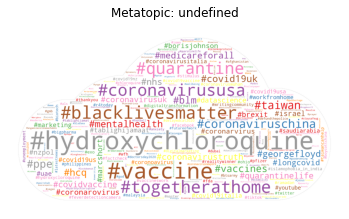

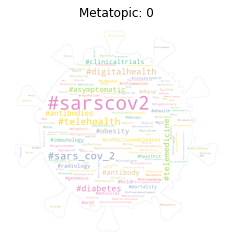

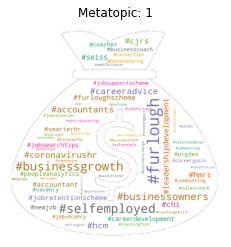

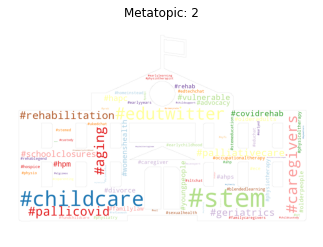

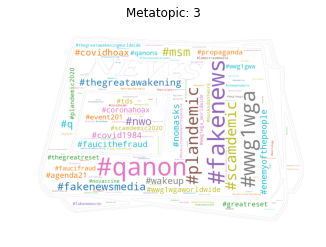

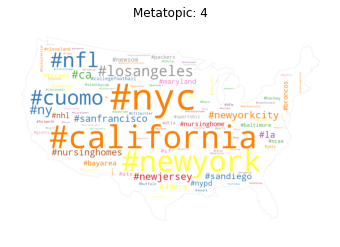

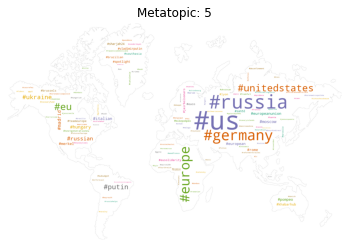

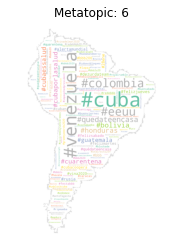

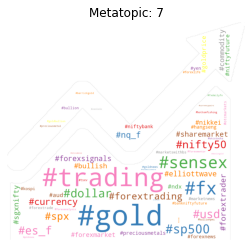

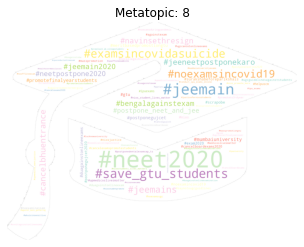

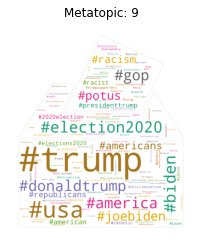

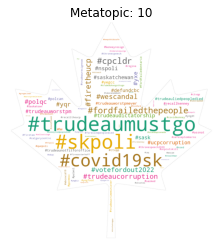

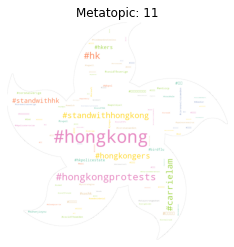

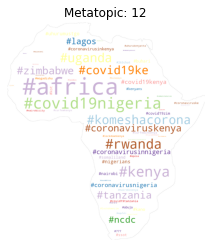

In [9]:
# generate Word Cloud for every metatopic
for index, metatopic in enumerate(data):
    make_wordcloud(metatopic_hashtags_counter[metatopic['name']],
                   title=metatopic['name'], max_words=250,
                   colormap=random.choice(colormaps), mask=f"masks2/topic_{metatopic['name']}.png")

## Circle Chart

In [9]:
events = {'Pfizer Authorization': '2020-12-11',
         'Cases Peak': '2021-01-08',
         'First Lockdown': '2020-03-23'}
# DO NOT USE 'purple'
events_colors = {'Pfizer Authorization': (Color("#e03010"), Color("#f29a8a")),
                 'Cases Peak': (Color("#196fe0"), Color("#79a9e8")),
                 'First Lockdown': (Color("#30e010"), Color("#9af28a"))}

### File load

In [10]:
def get_dates():
    file_names = os.listdir(TWEETS_PIPED_PATH)
    return [name.replace('parsed_', '').replace('.parquet', '') for name in file_names]

In [25]:
with open(TRENDS_RAW_PATH, 'rb') as f_trends_raw, open(TOPICS_PATH, 'rb') as f_topics:
    trends_raw = pkl.load(f_trends_raw)[0]
    trends_raw = {k: v for k, v in trends_raw.items() if not k.startswith('Pos') and not k.startswith('Neg')}
    topics = pkl.load(f_topics)[0]
    topic_labels = {k: v[:4] for k, v in topics.items()}
    topic_labels = {k: "\n".join(v) for k, v in topic_labels.items()}
    dates = get_dates()

### Events' counts

In [26]:
def get_event_counts(event_date, topics, trends, n=10):
    try:
        d_i = dates.index(event_date) # may throw if an invalid date
        l_i = max(0, d_i - DATES_INTERVAL)
        r_i = min(len(dates), d_i + DATES_INTERVAL + 1)
        # compute the sum of the trends over the interval
        try:
            interval_counts = {topic: sum(trends[str(topic)][l_i:r_i]) for topic in topics}
        except KeyError:
            interval_counts = {topic: sum(trends[topic][l_i:r_i]) for topic in topics}
        # sort the topics by their count
        interval_counts = dict(sorted(interval_counts.items(), key=lambda item: item[1], reverse=True))
        # keep top n
        try:
            interval_counts = {topic_labels[k]: interval_counts[k] for k in list(interval_counts)[:n]}
        except KeyError:
            interval_counts = {k: interval_counts[k] for k in list(interval_counts)[:n]}
        return interval_counts
    except ValueError:
        return None

### CircleChart builder

In [27]:
def make_circlechart(data, colors, ax, title=None):
    labels, values = zip(*data)
    circles = circlify.circlify(values, show_enclosure=False,
                                target_enclosure=circlify.Circle(x=0, y=0, r=1))
    # Title
    if not title is None:
        ax.set_title(f'{title}\n{events[title]}', fontsize=40)
    # Remove axes
    ax.axis('off')
    # Find axis boundaries
    lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r) for circle in circles)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    # print circles
    for circle, label, color in zip(circles, labels, colors):
        x, y, r = circle
        ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color))
        ax.annotate(label, (x, y), va='center', ha='center', fontsize=150*r)

In [28]:
def make_circlecharts(events_counts):
    fig, ax = plt.subplots(len(events_counts), 1, figsize=(20, 60))
    handles = []
    labels = [event_counts.keys() for (_, event_counts) in events_counts.items()]
    common_labels = set.intersection(*map(set, labels))
    for i, (event, event_counts) in enumerate(events_counts.items()):
        # Generate colors for circles
        c_start, c_end = events_colors[event]
        colors = map(lambda c: c.hex_l, c_start.range_to(c_end, len(event_counts)))
        colors = list(colors)
        # Create legend for circles
        handle = mpatches.Patch(color=colors[0], label=f'{event}')
        handles.append(handle)
        # Set common labels color to purple
        labels = list(event_counts.keys())
        color_mapper = lambda e: 'purple' if labels[e[0]] in common_labels else e[1]
        colors = np.array(list(map(color_mapper, enumerate(colors))))
        # Plot circles
        make_circlechart(event_counts.items(), colors, ax[i], title=event)
    handle = mpatches.Patch(color='purple', label=f'Common subjects')
    handles.append(handle)
    fig.legend(handles=handles, fontsize=30, loc='upper right')
    plt.tight_layout(pad=0)
    print(fig)
    return fig

In [29]:
events_counts = {}
for event, event_date in events.items():
    events_counts[event] = get_event_counts(event_date, topics, trends_raw)

/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12510 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 38283 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_

Figure(1440x4320)


/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 38283 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20652 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0,

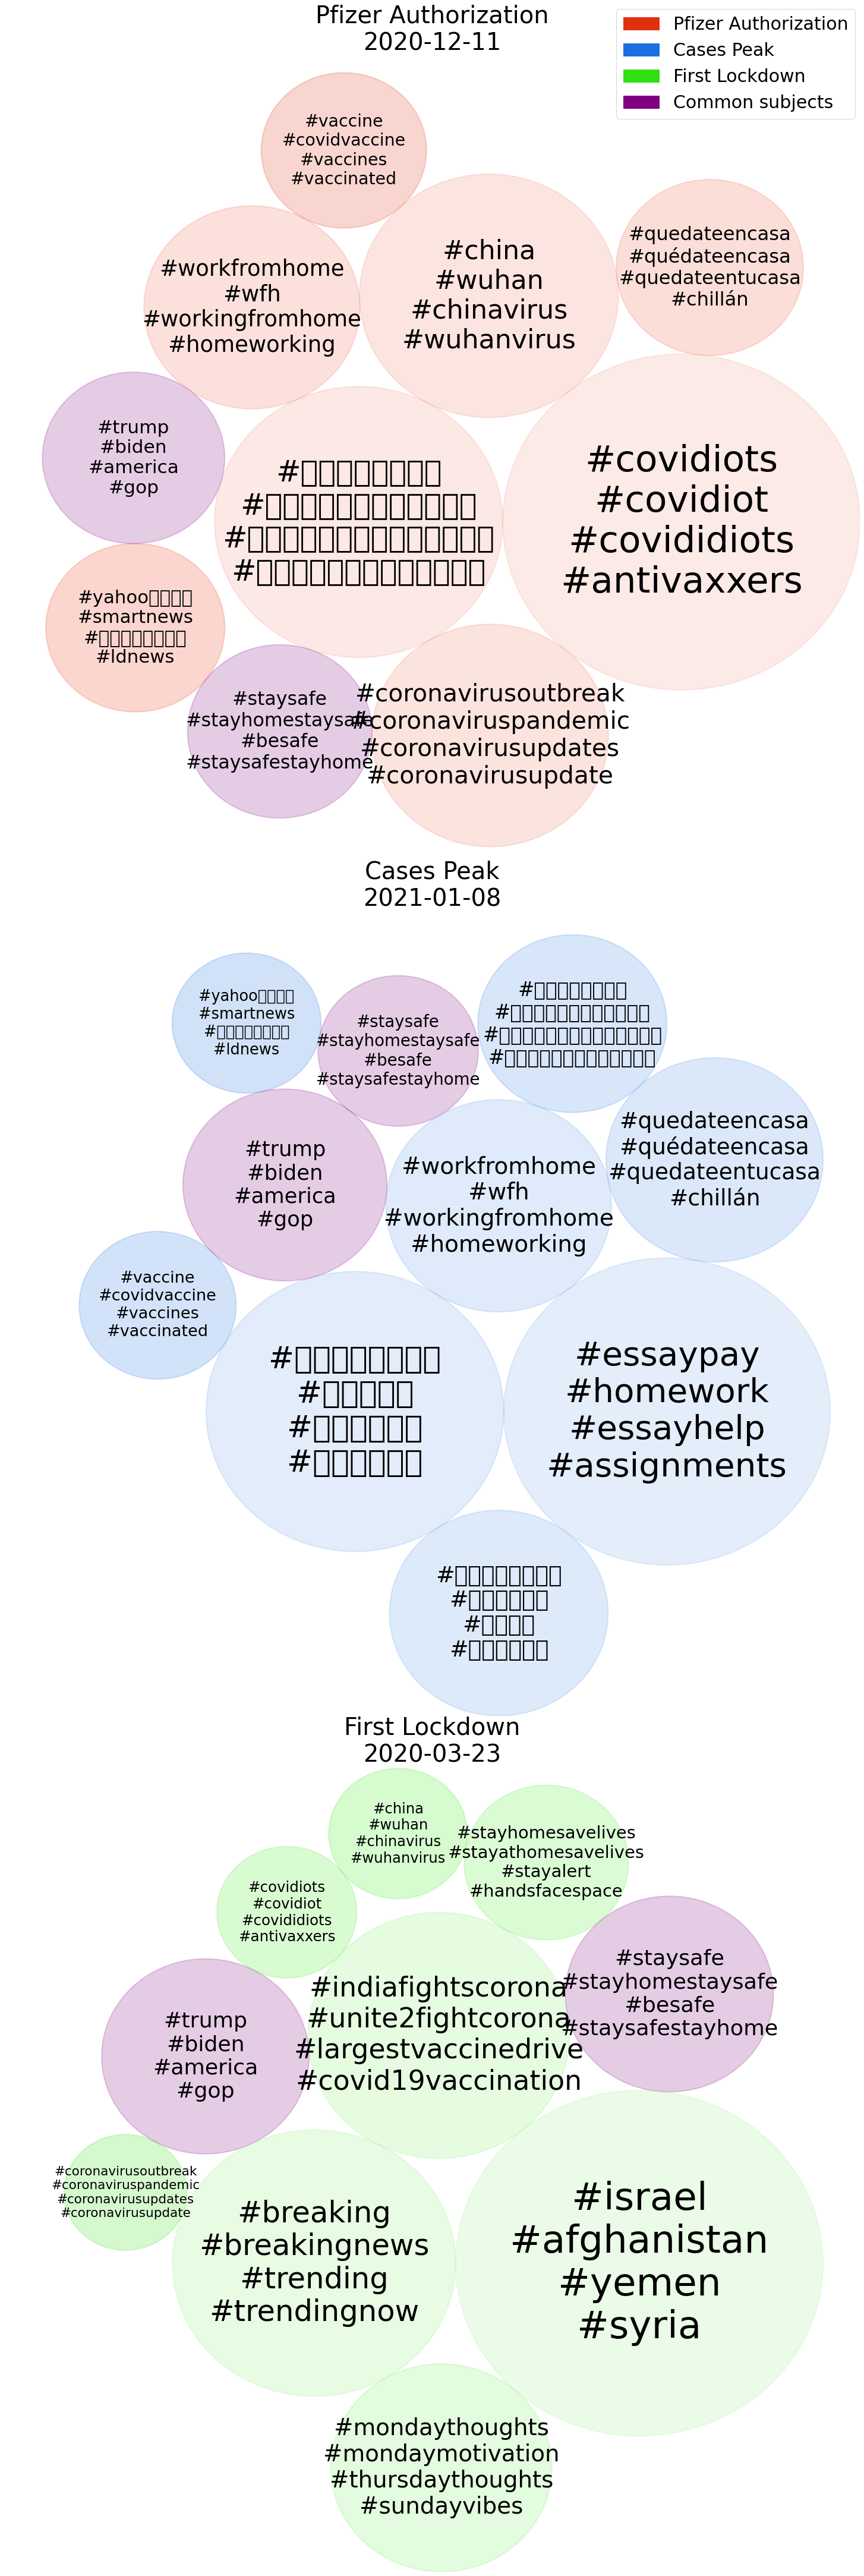

In [30]:
fig = make_circlecharts(events_counts)
fig.savefig("../visualizations/plots2/bubble_chart.svg")
fig.savefig("../visualizations/plots2/bubble_chart.png")

In [16]:
# Load topic trends
CLUSTERED_TOPIC_TRENDS = "/mlodata1/raileanu/bert_clusters_trends.pkl"
with open(CLUSTERED_TOPIC_TRENDS, 'rb') as f:
    trends = pkl.load(f)
    
# Re-label trends
model = BERTopic(verbose=True).load(REDUCED_MODEL_PATH)
topic_info_df = model.get_topic_info()
topic_id_to_name = pd.Series(topic_info_df['Name'].values, index=topic_info_df['Topic']).to_dict()
trends = {topic_id_to_name[k].replace('_', '\n'): v for k, v in trends.items() if k in topic_id_to_name}
# Remove numbers
trends = {''.join([i for i in k if not i.isdigit()]): v for k, v in trends.items()}

NameError: name 'BERTopic' is not defined

In [21]:
dates = pd.date_range(date(2019, 12, 31), date(2021, 10, 1) - timedelta(days=1), freq='d').strftime('%Y-%m-%d').to_list()

In [34]:
events_counts = {}
for event, event_date in events.items():
    events_counts[event] = get_event_counts(event_date, trends.keys(), trends)

Figure(1440x4320)


/opt/conda/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/opt/conda/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 12517 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/opt/conda/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/opt/conda/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/opt/conda/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 33258 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/opt/conda/lib/python3.8/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 27665 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_H

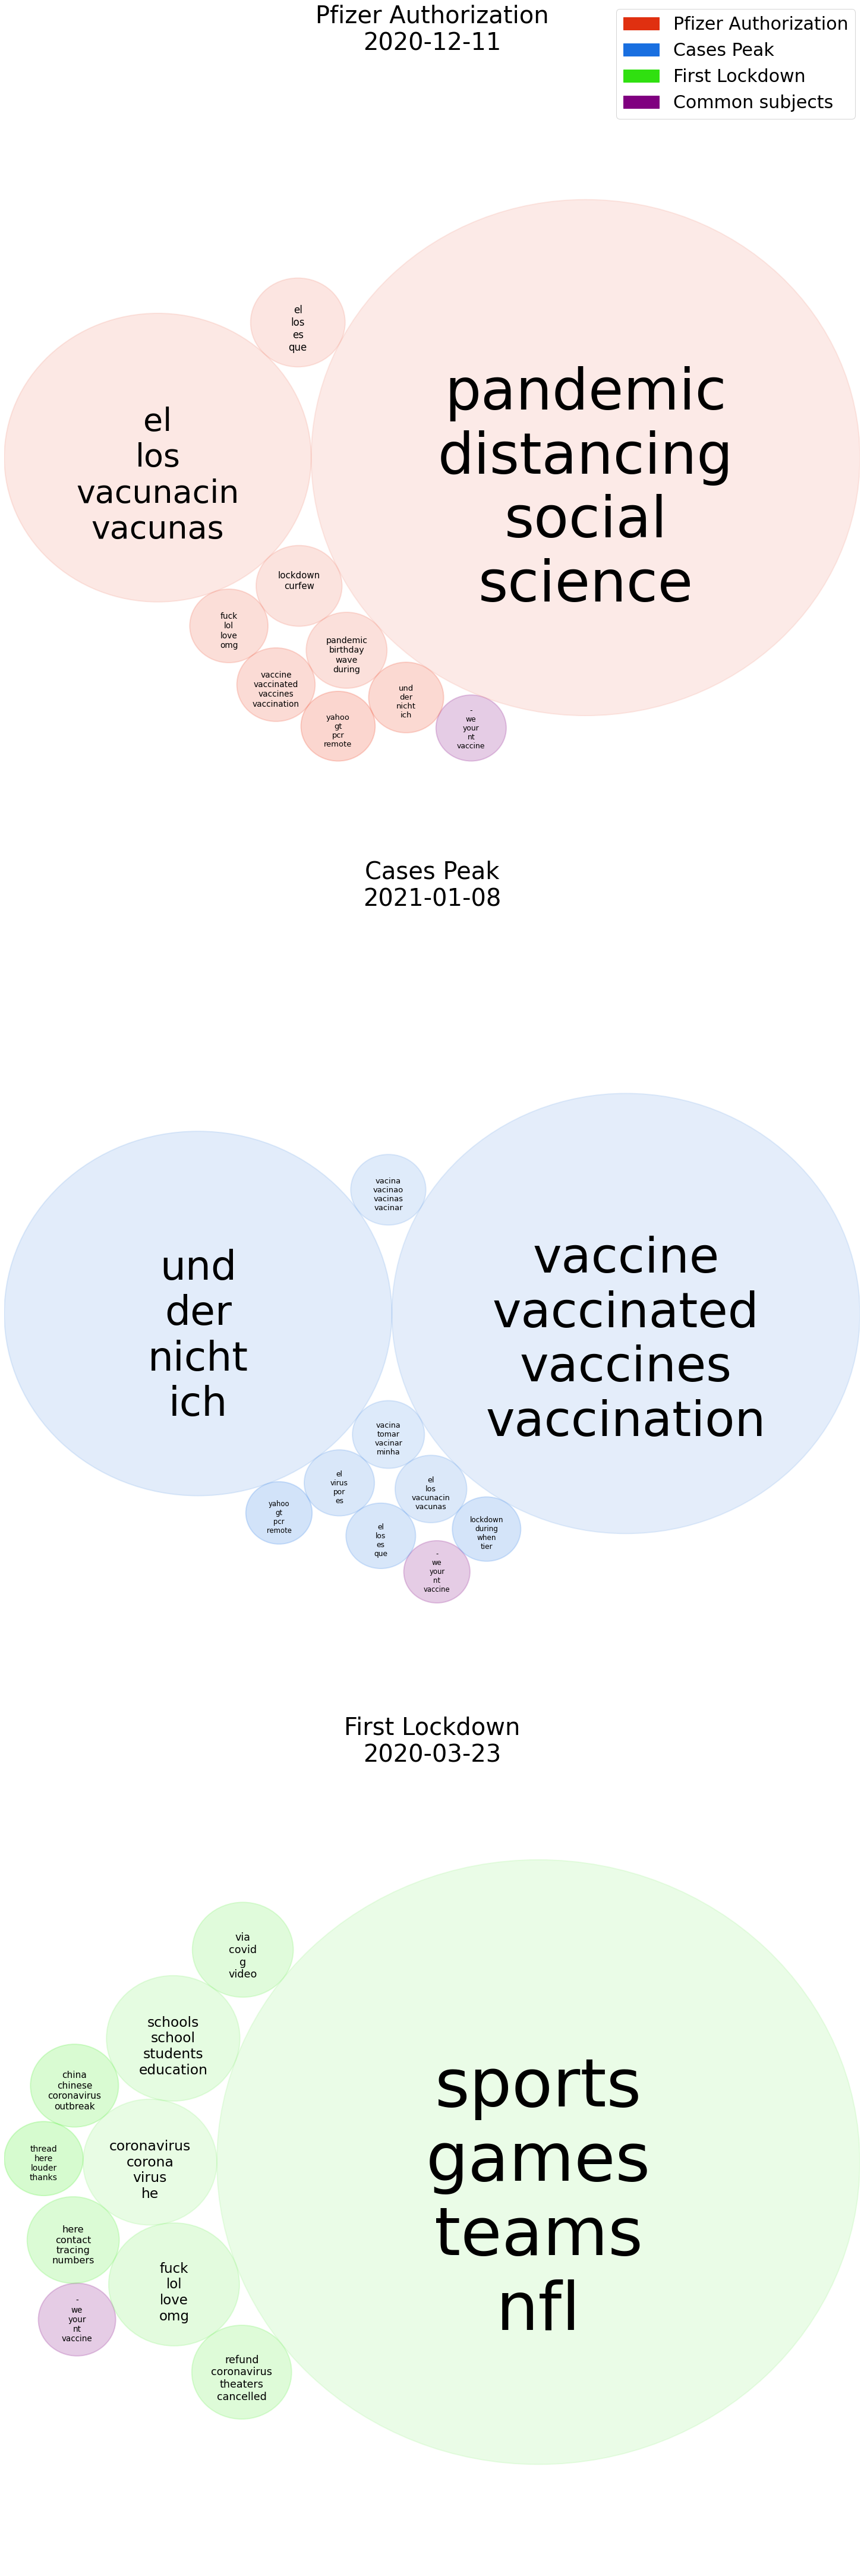

In [35]:
make_circlecharts(events_counts)
fig.savefig("../visualizations/plots2/bertopic_bubble_chart.svg")
fig.savefig("../visualizations/plots2/bertopic_bubble_chart.png")